# BENG 125: Tryptophan Operon Dynamics

In [1]:
# Analysis
from collections import defaultdict
import numpy as np
import sympy as sp
import pandas as pd
from numpy.linalg import eig, eigvals, det
from scipy.integrate import odeint
from scipy.optimize import fsolve

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Configure visualizations
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16 , 12
pylab.rcParams['axes.titlesize'] = 20
pylab.rcParams['axes.labelsize'] = 16
pylab.rcParams['xtick.labelsize'] = 14
pylab.rcParams['ytick.labelsize'] = 14
pylab.rcParams['legend.fontsize'] = 14
sns.set_style('ticks')
palette = ["#1E88E5", "#43A047", "#e53935", "#5E35B1", "#FFB300", "#00ACC1", "#3949AB", "#F4511E"]
sns.set_palette(palette)

## Define Constants and ODE's

In [2]:
# Default Parameters
params0 = {'a_1':0.9, 'a_2':0.02, 'a_3':0.0, 'a_4':0.024, 'a_5':430.0, 'a_6':-7.5,
           'k':0.005, 'k_i':2283.0, 'r':10.0, 'u_R':0.4}

In [3]:
# Temporary Parameters
params = {'a_1':0.9, 'a_2':0.02, 'a_3':0.0, 'a_4':0.024, 'a_5':430.0, 'a_6':-7.5,
           'k':0.005, 'k_i':2283.0, 'r':10.0, 'u_R':0.4}

In [4]:
def trp_eqs(v, params):
    """
    Define parameter and ODE's describing the trp operon
    x = x[0] : mRNA conc
    y = x[1] : enzyme conc
    z = x[2] : trp conc
    """
    x = v[0]
    y = v[1]
    z = v[2]
    
    # Constants
    T = 0.0156
    u_m = 0.0312
    a_1 = params['a_1']
    a_2 = params['a_2']
    a_3 = params['a_3']
    a_4 = params['a_4']
    a_5 = params['a_5']
    a_6 = params['a_6']
    k = params['k']
    k_i = params['k_i']
    r = params['r']
    u_R = params['u_R']
    u = u_R * u_m
    
    # ODE's
    dx = (z+1)/(1+(1+r)*z) - (a_1 + u)*x
    dy = x - (a_2+u)*y
    dz = y*((k_i**2)/((k_i**2)+(z**2))) - (a_3 + u)*z - a_4*(z/(z+1)) - a_5*(1+a_6*u)*u*(z/(z+k))
    
    return [dx, dy, dz]

In [5]:
def trp_dynamics(v, t, params):
    """
    Helper function for simulating trp operon dynamics over time
    """
    return trp_eqs(v, params)

## Stability Analysis

##### u_R = 0.4

In [24]:
(x, y, z) = sp.symbols('x, y, z', real=True)

In [25]:
params = params0
params['u_R'] = 0.4
dx, dy, dz = trp_eqs((x, y, z), params)
params = params0

In [26]:
A = sp.Matrix([dx, dy, dz])

In [27]:
J = A.jacobian([x, y, z])
J

Matrix([
[-0.91248,                              0,                                                                                             -21.0*(z + 1)/(21.0*z + 1)**2 + 1/(21.0*z + 1)],
[       1,                       -0.03248,                                                                                                                                          0],
[       0, 25000000.0/(z**2 + 25000000.0), -50000000.0*y*z/(z**2 + 25000000.0)**2 + 0.024*z/(z + 1)**2 + 6.7871232*z/(z + 0.005)**2 - 0.01248 - 0.024/(z + 1) - 6.7871232/(z + 0.005)]])

In [28]:
params = params0
params['u_R'] = 0.4
init_cond = [0.0, 0.0, 0.0]
x_star , y_star, z_star = fsolve(trp_eqs, init_cond, args=(params,))
params = params0
x_star, y_star, z_star

(0.21646680677425642, 6.6646184351679931, 0.25492059275453566)

In [29]:
J_atFP = J.subs([(x, x_star), (y, y_star), (z, z_star)])
J_atFP

Matrix([
[-0.91248,                0, -0.495480803907942],
[       1,         -0.03248,                  0],
[       0, 0.99999999740062, -0.530032850018078]])

In [30]:
trace = J_atFP.trace()
trace

-1.47499285001808

In [31]:
determinant = J_atFP.det()
determinant

-0.511189571919496

In [32]:
J_atFP = np.array(J_atFP).astype(np.float64)
eig_vals = eigvals(J_atFP)
eig_vals

array([-1.36116124+0.j        , -0.05691580+0.61017588j,
       -0.05691580-0.61017588j])

In [33]:
np.iscomplex(eig_vals).any()

True

## Simulate Dynamics

In [7]:
v0 = [0.0, 0.0, 0.0]
t = np.linspace(0, 1000, 5000)

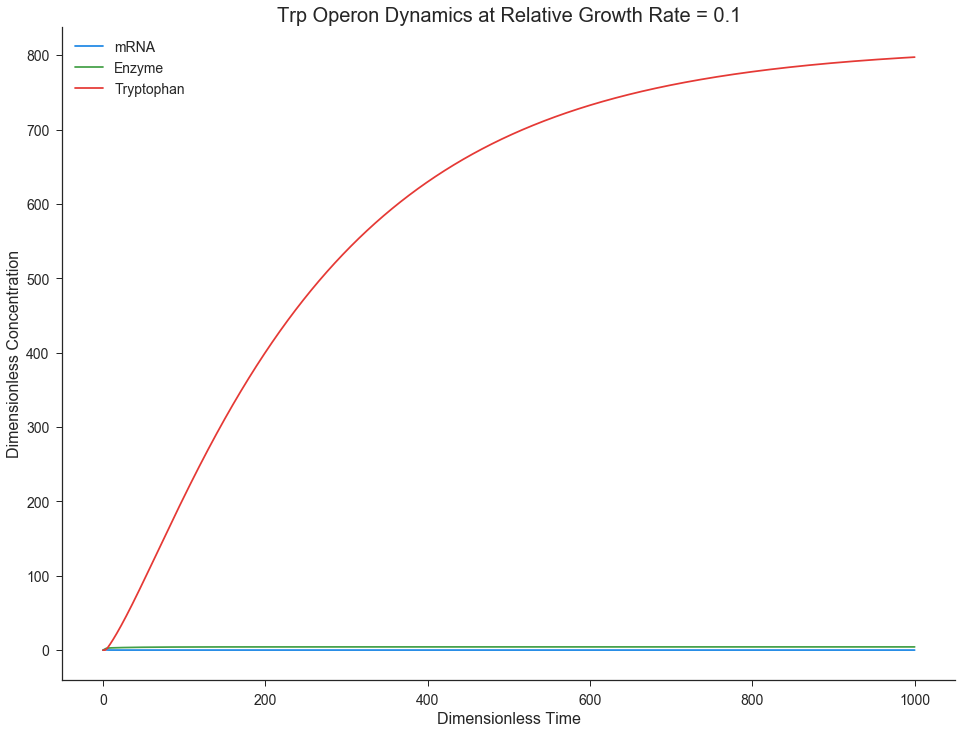

In [8]:
# Dynamics at low growth rate (u_R = 0.1)
params = params0
params['u_R'] = 0.1
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig, ax = plt.subplots()
ax.plot(t, sol[:,0], label='mRNA')
ax.plot(t, sol[:,1], label='Enzyme')
ax.plot(t, sol[:,2], label='Tryptophan')
plt.xlabel('Dimensionless Time')
plt.ylabel('Dimensionless Concentration')
plt.legend(loc='best')
plt.title('Trp Operon Dynamics at Relative Growth Rate = 0.1')
sns.despine()
fig.savefig('dynamics_img/dynamics_uR_low.png')

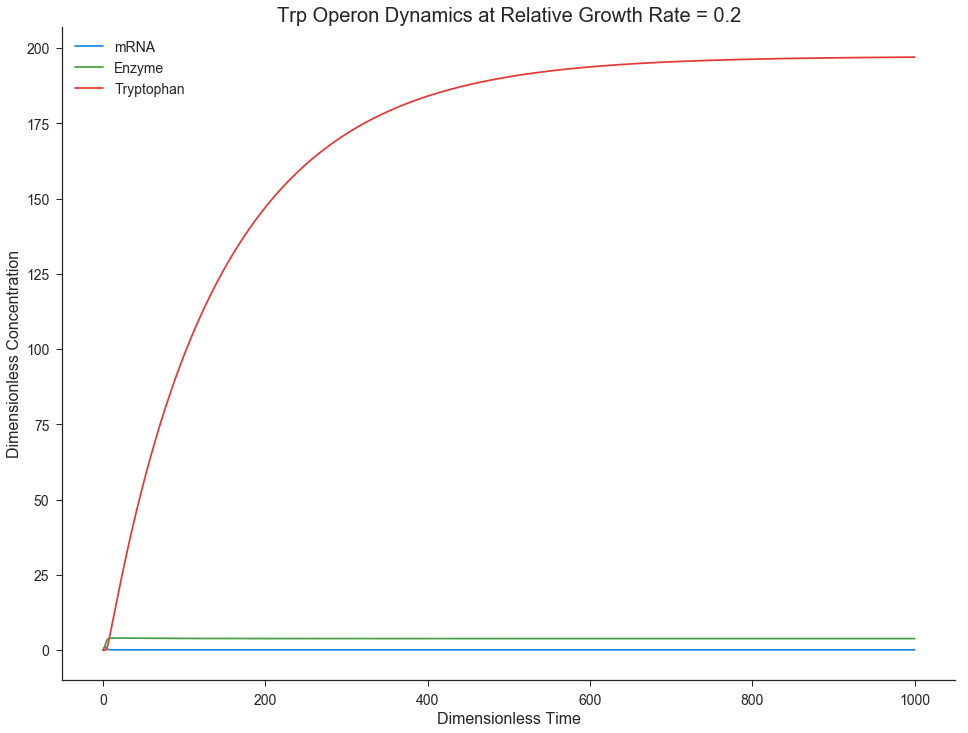

In [9]:
# Dynamics at low-low-medium growth rate (u_R = 0.2)
params = params0
params['u_R'] = 0.2
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig, ax = plt.subplots()
ax.plot(t, sol[:,0], label='mRNA')
ax.plot(t, sol[:,1], label='Enzyme')
ax.plot(t, sol[:,2], label='Tryptophan')
plt.xlabel('Dimensionless Time')
plt.ylabel('Dimensionless Concentration')
plt.legend(loc='best')
plt.title('Trp Operon Dynamics at Relative Growth Rate = 0.2')
sns.despine()
fig.savefig('dynamics_img/dynamics_uR_low-low-med.png')

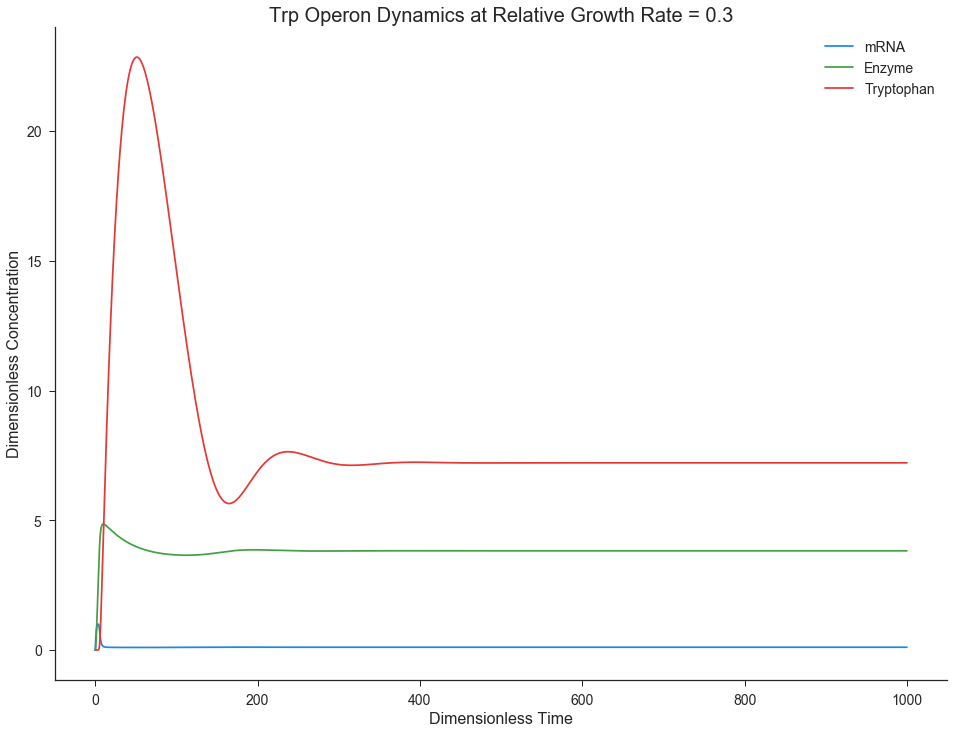

In [10]:
# Dynamics at low-medium growth rate (u_R = 0.3)
params = params0
params['u_R'] = 0.3
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig, ax = plt.subplots()
ax.plot(t, sol[:,0], label='mRNA')
ax.plot(t, sol[:,1], label='Enzyme')
ax.plot(t, sol[:,2], label='Tryptophan')
plt.xlabel('Dimensionless Time')
plt.ylabel('Dimensionless Concentration')
plt.legend(loc='best')
plt.title('Trp Operon Dynamics at Relative Growth Rate = 0.3')
sns.despine()
fig.savefig('dynamics_img/dynamics_uR_lo-med.png')

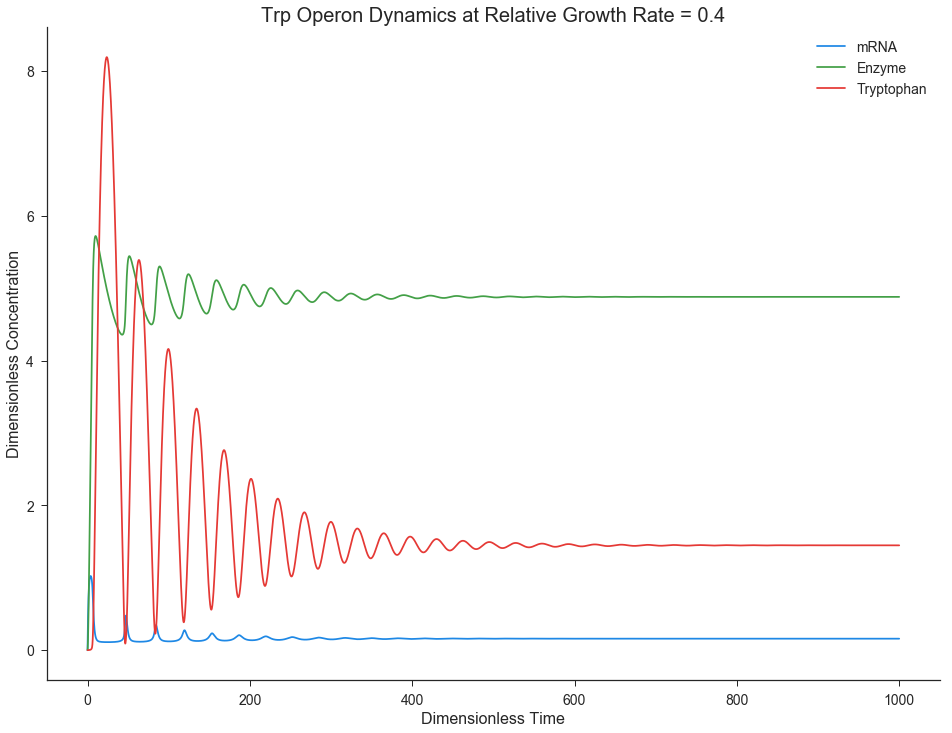

In [11]:
# Dynamics at medium growth rate (u_R = 0.4)
params = params0
params['u_R'] = 0.4
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig, ax = plt.subplots()
ax.plot(t, sol[:,0], label='mRNA')
ax.plot(t, sol[:,1], label='Enzyme')
ax.plot(t, sol[:,2], label='Tryptophan')
plt.xlabel('Dimensionless Time')
plt.ylabel('Dimensionless Concentration')
plt.legend(loc='best')
plt.title('Trp Operon Dynamics at Relative Growth Rate = 0.4')
sns.despine()
fig.savefig('dynamics_img/dynamics_uR_med.png')

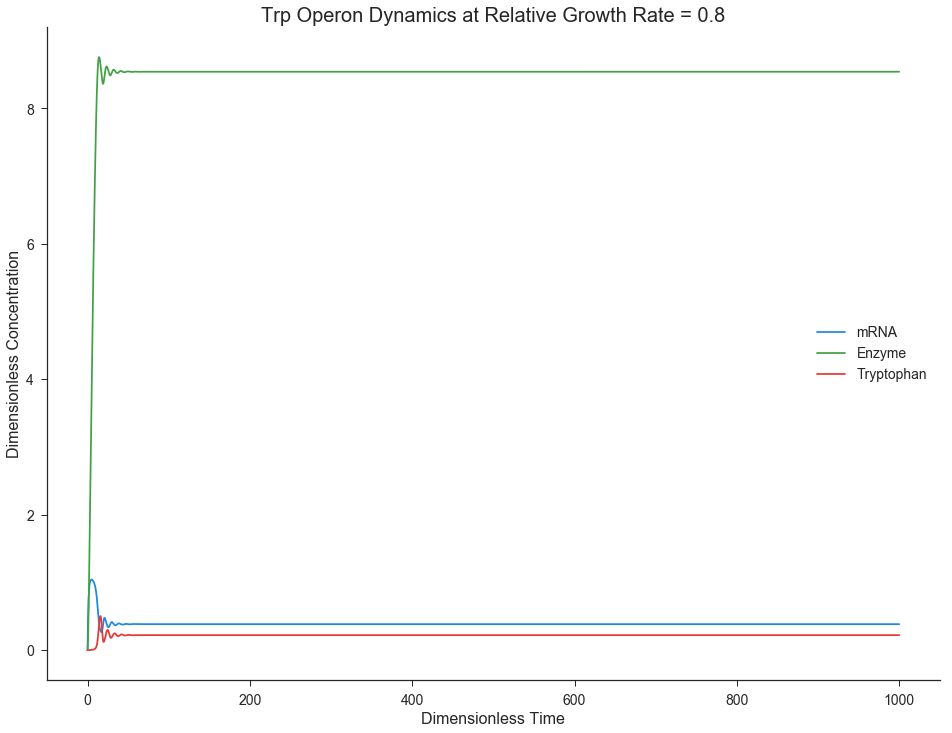

In [12]:
# Dynamics at high growth rate (u_R = 0.8)
params = params0
params['u_R'] = 0.8
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig, ax = plt.subplots()
ax.plot(t, sol[:,0], label='mRNA')
ax.plot(t, sol[:,1], label='Enzyme')
ax.plot(t, sol[:,2], label='Tryptophan')
plt.xlabel('Dimensionless Time')
plt.ylabel('Dimensionless Concentration')
plt.legend(loc='best')
plt.title('Trp Operon Dynamics at Relative Growth Rate = 0.8')
sns.despine()
fig.savefig('dynamics_img/dynamics_uR_high.png')

## Varying r

In [13]:
# Initial conditions and different u_R and r values for graphing figure 2
init_cond = [0.0, 0.0, 0.0]
u_R_vals = np.arange(0.0, 1.0, 0.01)
r_vals = [5.0, 10.0, 20.0]

In [14]:
# Solve for steady state solutions of mRNA, enzyme, and trp for each r and u_R combination
params = params0
x_stars = defaultdict(list)
y_stars = defaultdict(list)
z_stars = defaultdict(list)
for r in r_vals:
    params['r'] = r
    for u_R in u_R_vals:
        params['u_R'] = u_R
        x_star , y_star, z_star = fsolve(trp_eqs, init_cond, args=(params,))
        x_stars[r].append(x_star)
        y_stars[r].append(y_star)
        z_stars[r].append(z_star)
params = params0

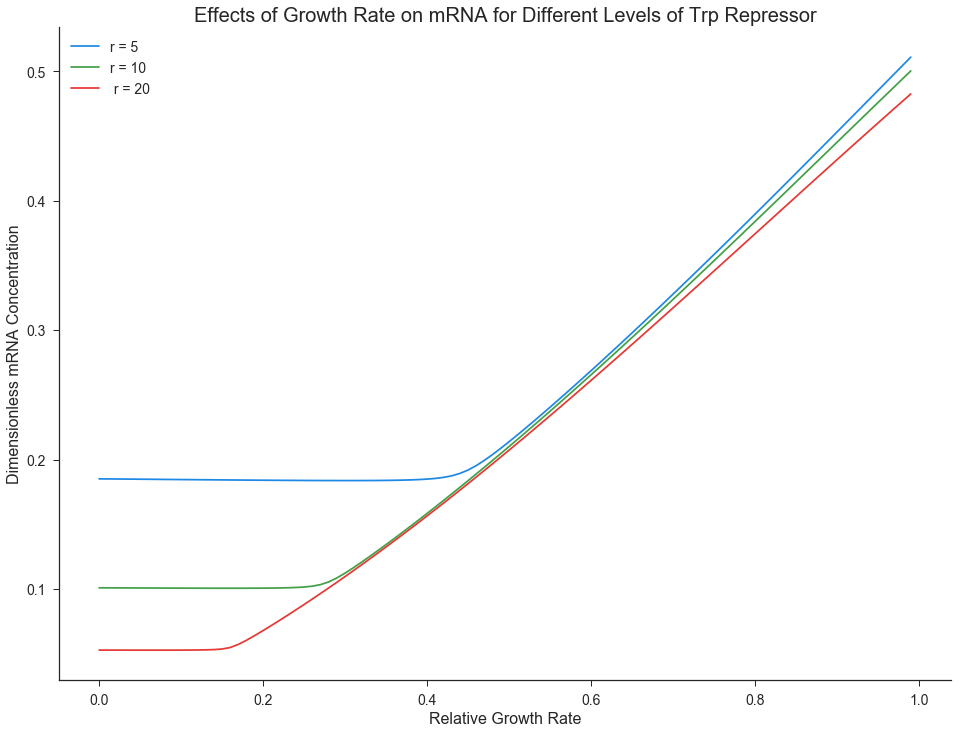

In [15]:
fig, ax = plt.subplots()
ax.plot(u_R_vals, x_stars[5.0], label='r = 5')
ax.plot(u_R_vals, x_stars[10.0], label='r = 10')
ax.plot(u_R_vals, x_stars[20.0], label=' r = 20')
plt.xlabel('Relative Growth Rate')
plt.ylabel('Dimensionless mRNA Concentration')
plt.legend(loc='best')
plt.title('Effects of Growth Rate on mRNA for Different Levels of Trp Repressor')
sns.despine()
fig.savefig('fig2_img/mRNA_uR_r.png')

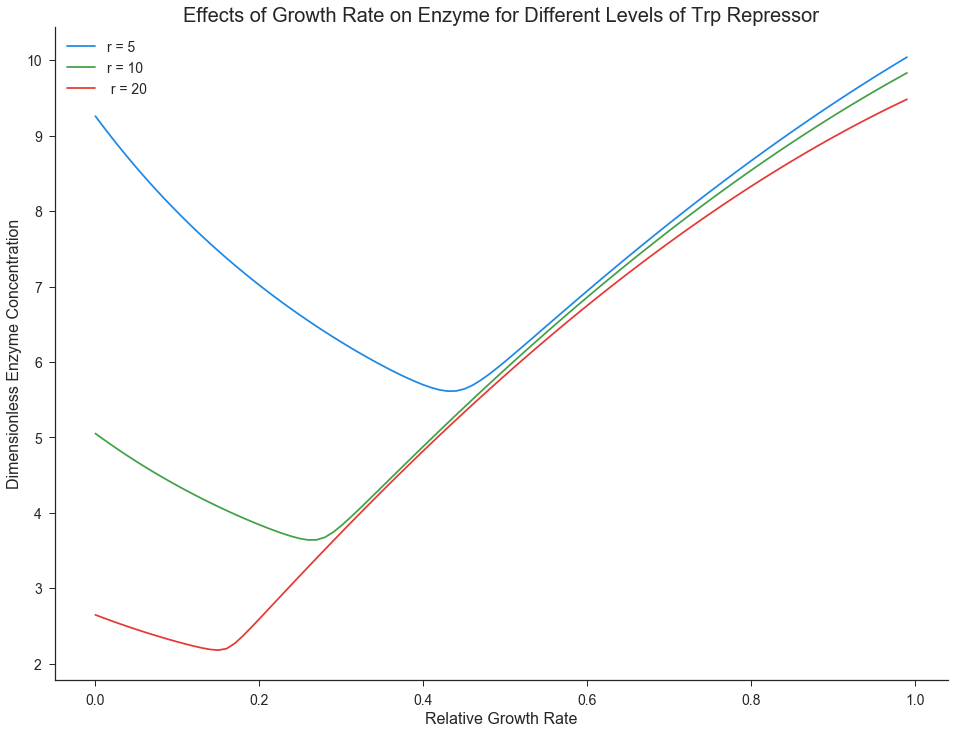

In [16]:
fig, ax = plt.subplots()
ax.plot(u_R_vals, y_stars[5.0], label='r = 5')
ax.plot(u_R_vals, y_stars[10.0], label='r = 10')
ax.plot(u_R_vals, y_stars[20.0], label=' r = 20')
plt.xlabel('Relative Growth Rate')
plt.ylabel('Dimensionless Enzyme Concentration')
plt.legend(loc='best')
plt.title('Effects of Growth Rate on Enzyme for Different Levels of Trp Repressor')
sns.despine()
fig.savefig('fig2_img/enzyme_uR_r.png')

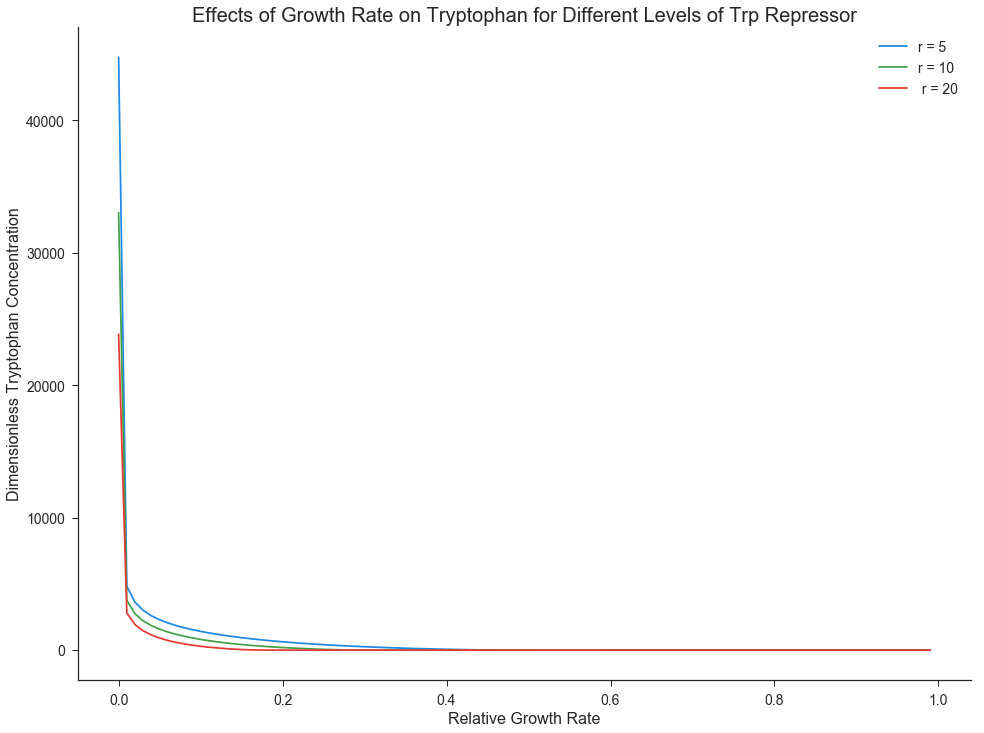

In [17]:
fig, ax = plt.subplots()
ax.plot(u_R_vals, z_stars[5.0], label='r = 5')
ax.plot(u_R_vals, z_stars[10.0], label='r = 10')
ax.plot(u_R_vals, z_stars[20.0], label=' r = 20')
plt.xlabel('Relative Growth Rate')
plt.ylabel('Dimensionless Tryptophan Concentration')
plt.legend(loc='best')
plt.title('Effects of Growth Rate on Tryptophan for Different Levels of Trp Repressor')
sns.despine()
fig.savefig('fig2_img/trp_uR_r.png')

## Varying k_i

In [18]:
# Initial conditions and different u_R and k_i values for graphing figure 3A
init_cond = [0.0, 0.0, 0.0]
u_R_vals = np.arange(0.0, 1.0, 0.01)
k_i_vals = [500.0, 2283.0, 5000.0]

In [19]:
# Solve for steady state solutions of mRNA, enzyme, and trp for each k_i and u_R combination
params = params0
x_stars = defaultdict(list)
y_stars = defaultdict(list)
z_stars = defaultdict(list)
for k_i in k_i_vals:
    params['k_i'] = k_i
    for u_R in u_R_vals:
        params['u_R'] = u_R
        x_star , y_star, z_star = fsolve(trp_eqs, init_cond, args=(params,))
        x_stars[k_i].append(x_star)
        y_stars[k_i].append(y_star)
        z_stars[k_i].append(z_star)
params = params0

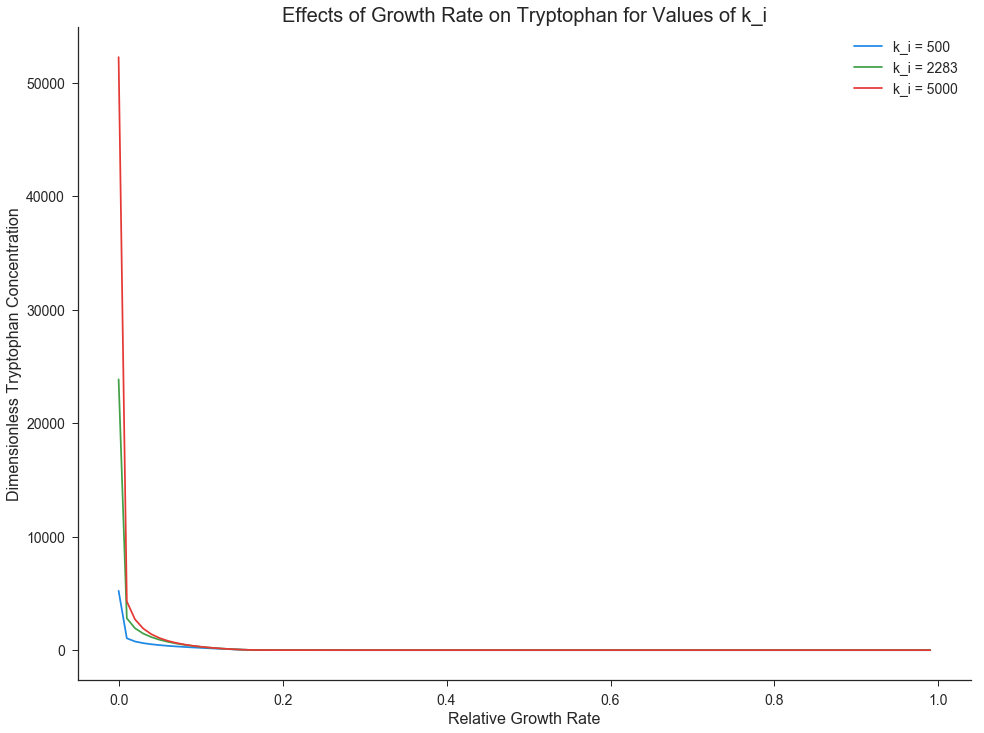

In [20]:
fig, ax = plt.subplots()
ax.plot(u_R_vals, z_stars[500.0], label='k_i = 500')
ax.plot(u_R_vals, z_stars[2283.0], label='k_i = 2283')
ax.plot(u_R_vals, z_stars[5000.0], label='k_i = 5000')
plt.xlabel('Relative Growth Rate')
plt.ylabel('Dimensionless Tryptophan Concentration')
plt.legend(loc='best')
plt.title('Effects of Growth Rate on Tryptophan for Values of k_i')
sns.despine()
fig.savefig('fig3_img/trp_uR_ki.png')

## Varying a_5

In [21]:
# Initial conditions and different u_R and a_5 values for graphing figure 3A
init_cond = [0.0, 0.0, 0.0]
u_R_vals = np.arange(0.0, 1.0, 0.01)
a_5_vals = [0.0, 100.0, 430.0, 600.0]

In [22]:
# Solve for steady state solutions of mRNA, enzyme, and trp for each a_5 and u_R combination
params = params0
x_stars = defaultdict(list)
y_stars = defaultdict(list)
z_stars = defaultdict(list)
for a_5 in a_5_vals:
    params['a_5'] = a_5
    for u_R in u_R_vals:
        params['u_R'] = u_R
        x_star , y_star, z_star = fsolve(trp_eqs, init_cond, args=(params,))
        x_stars[a_5].append(x_star)
        y_stars[a_5].append(y_star)
        z_stars[a_5].append(z_star)
params = params0

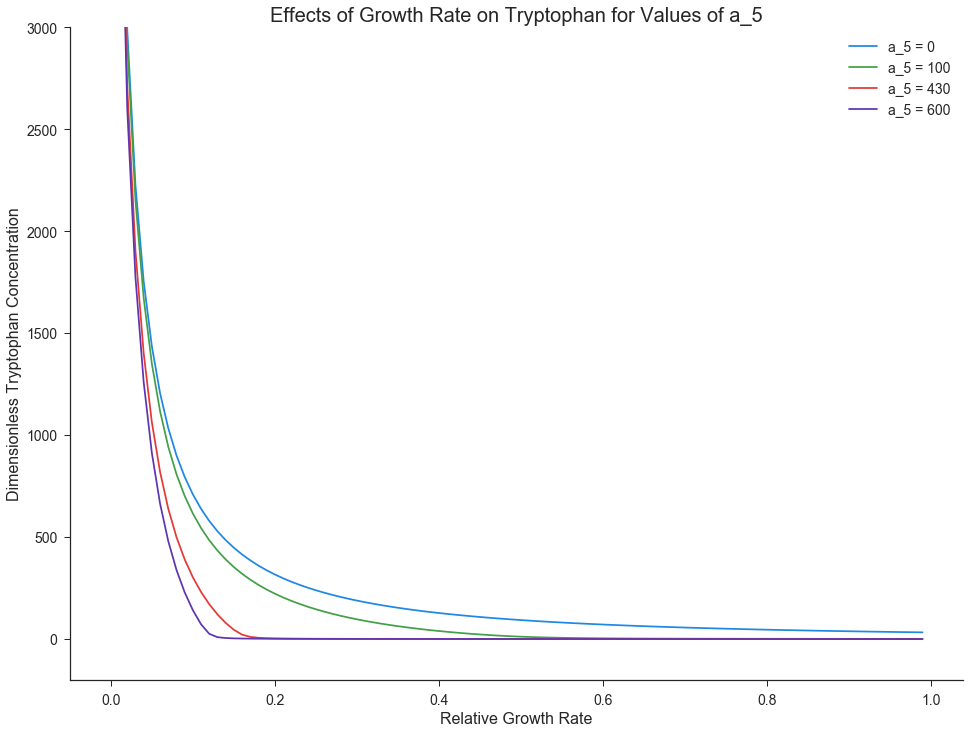

In [23]:
fig, ax = plt.subplots()
ax.plot(u_R_vals, z_stars[0.0], label='a_5 = 0')
ax.plot(u_R_vals, z_stars[100.0], label='a_5 = 100')
ax.plot(u_R_vals, z_stars[430.0], label='a_5 = 430')
ax.plot(u_R_vals, z_stars[600.0], label='a_5 = 600')
plt.xlabel('Relative Growth Rate')
plt.ylabel('Dimensionless Tryptophan Concentration')
plt.ylim(-200, 3000)
plt.legend(loc='best')
plt.title('Effects of Growth Rate on Tryptophan for Values of a_5')
sns.despine()
fig.savefig('fig3_img/trp_uR_a5.png')

## Dynamics in 3 Dimensional Space

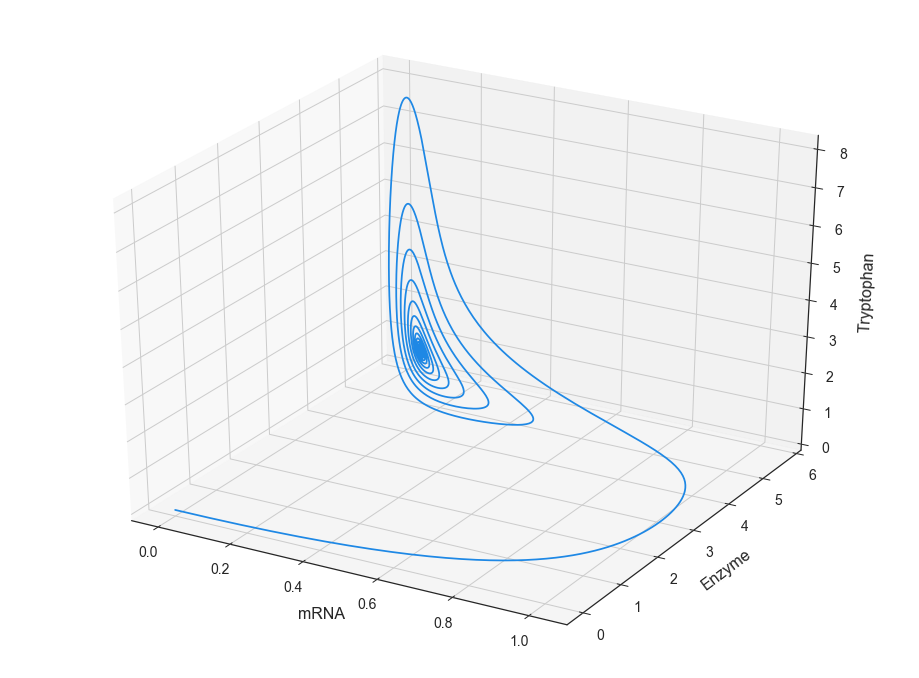

In [6]:
params = params0
params['u_R'] = 0.4
v0 = [0.0, 0.0, 0.0]
t = np.linspace(0, 1000, 10000)
sol = odeint(trp_dynamics, v0, t, args=(params,))
params = params0

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(sol[:,0],sol[:,1],sol[:,2])
ax.set_xlabel('mRNA', labelpad=14)
ax.set_ylabel('Enzyme', labelpad=14)
ax.set_zlabel('Tryptophan', labelpad=14)